# Import

In [1]:
import PyPDF2
import pandas as pd
import re
import numpy as np
import os
import fitz
from PIL import Image
import io
from functools import partial
import scipy
import skimage
import cv2 as cv
from scipy import ndimage as ndi
import copy
from numba import njit

from bs4 import BeautifulSoup

from collections import Counter

from sklearn.utils import shuffle
from scipy.spatial.distance import cdist

from skimage.morphology import remove_small_objects

import pylab
from matplotlib.colors import to_hex
from matplotlib.colors import to_rgb
from matplotlib.colors import rgb_to_hsv
import matplotlib.pyplot as plt

import simplekml

from skimage.io import imread
from scipy import ndimage as ndi
from skimage import feature
from skimage.color import rgb2gray 
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
import matplotlib.pyplot as plt
from skimage import filters

from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

from skimage.filters import median

import random
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
from tkinter import Canvas

import subprocess
import geojson

import gui
import glob

import json
from scrape_svg import *

from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000

%pdb
%load_ext autoreload
%autoreload 2
base_dir = '/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting'

Automatic pdb calling has been turned ON


In [3]:
table = pd.read_csv(
    base_dir + '/example_table.csv', 
    dtype=str, sep='\t'
)
table['Threatened Species'] = 'None mentioned'
table['Map'] = False
species = pd.read_csv('threatened_species_202010.csv')

Extract "Threatened Species" and "Map?" column.

In [3]:
example_folders = [x[0].replace('/','') + '_' + x[1].replace('/','') for x in table[['Reference Number', 'Date of notice']].values]

In [4]:
# Check for scientific names 
# Loop through pdf files. Convert pdf to text. Search for scientific names.
folders = os.listdir("./files")

In [5]:
folders_revised = []
for folder in folders:
    for example_folder in example_folders:
        if example_folder in folder:
            folders_revised.append(folder)

In [6]:
folders_revised = list(set(folders_revised))
len(folders_revised)

93

In [7]:
folders=folders_revised

In [66]:
# Loop through folders
for folder in folders_revised:
    print(folder)
    try:
        fn = folder.split('_')[0] + '_' + folder.split('_')[1] + '_combined.pdf'
        pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
        pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
    except:
        try:
            fn = folder + '_combined.pdf'
            pdf_file_obj = open(base_dir + '/files/' + folder + '/' + fn, 'rb')
            pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
        except:
            continue

    try:
        pages = [
            pdf_reader.getPage(i).extractText().replace('\n', '') 
            for i in range(pdf_reader.numPages)
        ]
    except:
        continue
    text = ''.join(pages)
    
    text_lower = text.lower()
    sci_name = species['Scientific Name'].apply(lambda x: x.lower()).values
    comm_name = species['Common Name'].loc[
        np.logical_and(
            species['Common Name'] != 'a shrub', species['Common Name'] != '-'
        )
    ].apply(lambda x: x.lower()).values

    [sci_name_exist, comm_name_exist] = [
        [
            species['Common Name'].values[i] + ', ' 
            + species['Scientific Name'].values[i] + ' (' 
            +  species['Threatened status'].values[i] + ')' 
            for i in range(len(name)) if name[i] in text.lower()
        ]
        for name in [sci_name, comm_name]
    ]
    
    if 'coordinates' in text.lower() or 'latitude' in text.lower() or 'longitude' in text.lower() or ' map ' in text.lower():
        coordinates_mentioned = True
    else:
        coordinates_mentioned = False

    species_mentioned = sorted(
        list(set(sci_name_exist).union(set(comm_name_exist)))
    )
    species_mentioned = ', '.join(species_mentioned)
    
#     Extract text coordinates
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
#     text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)
#     points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
#     points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

    id_nums = folder.split('_')
    date = id_nums[1][:2] + '/' + id_nums[1][2:4] + '/' + id_nums[1][4:]
    ref_num = id_nums[0][:4] + '/' + id_nums[0][4:]
    table['Threatened Species'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = species_mentioned
    table['Map'].loc[np.logical_and(
        table['Date of notice'] == date, table['Reference Number'] == ref_num
    )] = coordinates_mentioned

NameError: name 'folders_revised' is not defined

In [13]:
table.to_csv('example_revised_table.csv', index=False, header=True)

In [20]:
coords = coords.reshape(int(len(coords)/2),2)
coords_new = np.zeros_like(coords)
coords_new[:,1] = coords[:,0]
coords_new[:,0] = coords[:,1]

In [3]:
pdf_file_obj = open('example_referral.pdf', 'rb')
pdf_reader = PyPDF2.PdfFileReader(pdf_file_obj)
pages = [pdf_reader.getPage(i).extractText().replace('\n', '') for i in range(pdf_reader.numPages)]

In [4]:
text = ''.join(pages)

Extract KML from text.

In [5]:
import fitz

In [6]:
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:)([0-9]{1}).([0-9]{1})([0-9]{2})', '\g<1>\g<2>\g<3>.\g<4>', text)
text = re.sub('([-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2})([N,S]{1})', '\g<1> \g<2>', text)

In [8]:
points_lat = re.findall('[-]?[0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{2} [N,S]{1}', text)
points_lon = re.findall('[-]?[0-9]{2,3}:[0-9]{2}:[0-9]{2}.[0-9]{2} [E,W]{1}', text)

In [9]:
def convert_to_decimal(old):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = old.replace(':',' ')
    new = new.split()
    new_dir = new.pop()
    return (abs(float(new[0]))+float(new[1])/60.0+float(new[2])/3600.0) * direction[new_dir]

In [10]:
points_lat = [convert_to_decimal(i) for i in points_lat]
points_lon = [convert_to_decimal(i) for i in points_lon]

In [11]:
len(points_lat)
# len(points_lon)

43

In [21]:
kml_coords = [(points_lon[i], points_lat[i]) for i in range(len(points_lat))]

In [22]:
kml_coords

[(116.09779999999999, -23.912388888888888),
 (116.1034, -23.90271111111111),
 (116.1288, -23.868069444444444),
 (116.1667, -23.837108333333333),
 (116.1847, -23.83203888888889),
 (116.2014, -23.83203888888889),
 (116.2429, -23.857950000000002),
 (116.2667, -23.87602777777778),
 (116.2847, -23.88202777777778),
 (116.3014, -23.88202777777778),
 (116.3167, -23.923008333333335),
 (116.3232, -23.94103888888889),
 (116.3231, -23.9528),
 (116.3059, -23.96666944444444),
 (116.29169999999999, -23.96666944444444),
 (116.2423, -24.002580555555557),
 (116.2818, -24.0853),
 (116.2837, -24.09245),
 (116.2835, -24.09570833333333),
 (116.2831, -24.097158333333333),
 (116.2824, -24.098488888888888),
 (116.2814, -24.099619444444443),
 (116.2799, -24.100580555555556),
 (116.27695, -24.1019),
 (116.27629999999999, -24.10068888888889),
 (116.2709, -24.07348888888889),
 (116.25835, -24.06573888888889),
 (116.22840000000001, -24.048269444444447),
 (116.2269, -24.047127777777778),
 (116.22585000000001, -24.04

In [25]:
import simplekml

trans_green_style = simplekml.Style()
trans_green_style.linestyle.width = 1.5
trans_green_style.polystyle.color = '7d00ff00'
trans_green_style.name = 'trans_green_style'

kml = simplekml.Kml()
kml.document.name = "Referral Name Text Extract"
pol1 = kml.newpolygon(name = "Referral Area", outerboundaryis=kml_coords)
pol1.style.linestyle.width = 1.5
pol1.style = trans_green_style

In [43]:
kml.save('simple_kml_test.kml')

In [18]:
direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
test = points_lat[0]

# Scrape Maps

In [31]:
file

'/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/files/20167684_07042016/20167684_07042016_combined.pdf'

In [1]:
folders = glob.glob(base_dir + '/files/20167676_01042016')

NameError: name 'glob' is not defined

In [2]:
folders = glob.glob(base_dir + '/files/*042016')

In [33]:
folder = folders[5]
print(folder)
id_num = folder.split('/')[-1]
subprocess.run('mkdir ' + base_dir + '/map_data/' + id_num, shell=True)
subprocess.run(
    'mkdir ' + base_dir + '/map_data/' + id_num + '/pages', shell=True
)

sub_dir = '/map_data/' + id_num
file = base_dir + '/files/' + id_num + '/' + id_num + '_combined.pdf'
try:
    pdf_file = fitz.open(file)
    zoom_factor = 1

    saved_pages = []
    for page_index in range(len(pdf_file)):
        # get the page itself
        page = pdf_file[page_index]
        page_size = page.mediabox_size[0]*page.mediabox_size[1]
        image_list = page.getImageList()
        image_sizes = np.array([im[2]*im[3] for im in image_list])
        save_page_image = ('legend' in page.getText().lower())

        if save_page_image:
            zoom_x = zoom_factor
            zomm_y = zoom_factor
            mat = fitz.Matrix(zoom_x, zomm_y) 
            pix = page.get_pixmap(matrix=mat)
            pix.writePNG(
                base_dir + sub_dir + '/pages/page-%i.png' % page.number
            )
            print('Saving page ' + str(page.number) + '.')
            saved_pages.append(page.number)

except:
    print('Could not open file.')

/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/files/20157598_12042016
Saving page 17.
Saving page 34.


mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object
mupdf: invalid page object


Saving page 41.
Saving page 65.
Saving page 68.
Saving page 70.
Saving page 75.
Saving page 78.
Saving page 83.
Saving page 128.
Saving page 130.
Saving page 137.
Saving page 139.
Saving page 143.
Saving page 145.
Saving page 147.
Saving page 152.
Saving page 159.
Saving page 174.
Saving page 175.
Saving page 176.
Saving page 181.
Saving page 182.
Saving page 185.
Saving page 188.
Saving page 189.
Saving page 190.


In [50]:
try:
    remaining_pages = np.genfromtxt(
        base_dir + sub_dir + '/remaining_pages.csv'
    ).astype(int).tolist()
except:
    remaining_pages = copy.deepcopy(saved_pages)

## Scrape SVG

In [38]:
file

'/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/files/20167684_07042016/20167684_07042016_combined.pdf'

In [4]:
import menu

In [8]:
folders = glob.glob(base_dir + '/files/*042016')
folder = folders[7]
print(folder)
id_num = folder.split('/')[-1]
sub_dir = '/map_data/' + id_num
file = base_dir + '/files/' + id_num + '/' + id_num + '_combined.pdf'
zoom_factor = 1

/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/files/20167691_29042016


In [11]:
root = tk.Tk()
root.geometry('640x480')
app = menu.Menu(
    root, file)
root.mainloop()

> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(42)scrape_bmp()
     40     for s in small_soup('image'):
     41         import pdb; pdb.set_trace()
---> 42         transform = convert_transform(s.parent.parent['transform'])
     43         img_width = abs(float(s['width'])*transform[0,0])
     44         img_height = abs(float(s['height'])*transform[1,1])

ipdb> s
--Call--
> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/acf/lib/python3.9/site-packages/bs4/element.py(1403)__getitem__()
   1401         return str(self).__hash__()
   1402 
-> 1403     def __getitem__(self, key):
   1404         """tag[key] returns the value of the 'key' attribute for the Tag,
   1405         and throws an exception if it's not there."""

ipdb> print(s)
*** NameError: name 's' is not defined
ipdb> u
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(42)scrape_bmp()
     40     for s in small_soup('image'):
     41         import pdb; pdb.set_

ipdb> s.parent
> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/acf/lib/python3.9/site-packages/bs4/element.py(1406)__getitem__()
   1404         """tag[key] returns the value of the 'key' attribute for the Tag,
   1405         and throws an exception if it's not there."""
-> 1406         return self.attrs[key]
   1407 
   1408     def __iter__(self):

ipdb> u
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(42)scrape_bmp()
     40     for s in small_soup('image'):
     41         import pdb; pdb.set_trace()
---> 42         transform = convert_transform(s.parent.parent['transform'])
     43         img_width = abs(float(s['width'])*transform[0,0])
     44         img_height = abs(float(s['height'])*transform[1,1])

ipdb> print(s)
<image height="242" width="1444" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABaQAAADyCAIAAAA9V1W+AAAACXBIWXMAAA7EAAAO
xAGVKw4bAAUmSklEQVR4nHS927IkO5IdBiAic1+qdp3umdEX02gSTaahkS/8FIpG
G9HImRH5IH0Jp8f6VNW+ZWYAAnyt

ipdb> print(s.parent)
<symbol id="im0" viewbox="0 0 1444 242">
<image height="242" width="1444" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABaQAAADyCAIAAAA9V1W+AAAACXBIWXMAAA7EAAAO
xAGVKw4bAAUmSklEQVR4nHS927IkO5IdBiAic1+qdp3umdEX02gSTaahkS/8FIpG
G9HImRH5IH0Jp8f6VNW+ZWYAAnyt5e5ZPcrqrrMrd2YEAnC4L19+Qf1X/+d/PO37
+XxurZZa3t/fSynbtv348eP5+cvT0/MY5Th6KXWM2vuYr9PpPP93u92u19vWtm3f
Wttqrdfr5Xbc5u/20/75+Tn/+fXrl/n56/zpcmnzQ9s2r1BGme98fXn5/Pi4XK5P
9pof+fj4PG63+fl5xXmNecH58+16O47bPt84nfoxB9J3e42Of/X5/3nHef3f/vDb
jx8/56VeX1/njfD1Od75sfnDusC+z2sdt2N9/3SyJ1q/vd5ujw+PHx8f8yPz1vOq
8805CbW2Yv+Zn57fmD/My80Pz9/OR55vjlLmFeaN5rxd7DWfcZ+zMeejtvXx3ueT
X2/XfV53327ru2t+Tmt+PuYUPcx5P5/e3uasvz89zsl+xpDaeq2rzNccTuc7dQ5n
Tp/9MD7W7K0xnx/OdQ1kYDB4kIeHh/m9P//++1//1V+vMd/WJJRR11OtPzZCG+Ua
f1k3XVNjUzrvMn//8HCeT325zGHOpfl4efm65nP9dmCQc7Hw4bO98FuMwR7rvB5/
iojNWLU7z0/MuZoDs1Wer319pXd73M2Wa11m3mJJ0b7Nr8+bT9mYM/A4F+nxYV1z
yt3lcwoG1nGt1tFtgvd1/yUh88rtul6XKZhzHtc9xmGPjWmsNtgpi2Ufdc3heY12
rbuJzRShuSLPcwN8+TLFfM4A

ipdb> s.parent.transform
--Return--
'matrix(.3596...64,26.465226)'
> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/acf/lib/python3.9/site-packages/bs4/element.py(1406)__getitem__()
   1404         """tag[key] returns the value of the 'key' attribute for the Tag,
   1405         and throws an exception if it's not there."""
-> 1406         return self.attrs[key]
   1407 
   1408     def __iter__(self):

ipdb> print(s.transform)
*** NameError: name 's' is not defined
ipdb> print(s.parent.transform)
*** NameError: name 's' is not defined
ipdb> u
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(42)scrape_bmp()
     40     for s in small_soup('image'):
     41         import pdb; pdb.set_trace()
---> 42         transform = convert_transform(s.parent.parent['transform'])
     43         img_width = abs(float(s['width'])*transform[0,0])
     44         img_height = abs(float(s['height'])*transform[1,1])

ipdb> print(s.transform)
None
ipdb> print(s.parent.par

ipdb> print(s.parent.transform)
None
ipdb> s.parent.transform
--Call--
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_svg.py(768)convert_transform()
    766     return use_coords, stroke, fill, obj_list
    767 
--> 768 def convert_transform(transform_string):
    769     transform = np.array(
    770         re.split(

ipdb> u
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(42)scrape_bmp()
     40     for s in small_soup('image'):
     41         import pdb; pdb.set_trace()
---> 42         transform = convert_transform(s.parent.parent['transform'])
     43         img_width = abs(float(s['width'])*transform[0,0])
     44         img_height = abs(float(s['height'])*transform[1,1])

ipdb> print(s)
<image height="242" width="1444" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABaQAAADyCAIAAAA9V1W+AAAACXBIWXMAAA7EAAAO
xAGVKw4bAAUmSklEQVR4nHS927IkO5IdBiAic1+qdp3umdEX02gSTaahkS/8FIpG
G9HImRH5IH0Jp8f6VNW+ZWYAAnyt5e5ZPcrqrrMrd2

ipdb> print(s.transform)
None
ipdb> print(s.parent.transform)
None
ipdb> print(s.parent.parent)
<g transform="matrix(.3596393,0,0,.35964,48.239164,26.465226)">
<symbol id="im0" viewbox="0 0 1444 242">
<image height="242" width="1444" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABaQAAADyCAIAAAA9V1W+AAAACXBIWXMAAA7EAAAO
xAGVKw4bAAUmSklEQVR4nHS927IkO5IdBiAic1+qdp3umdEX02gSTaahkS/8FIpG
G9HImRH5IH0Jp8f6VNW+ZWYAAnyt5e5ZPcrqrrMrd2YEAnC4L19+Qf1X/+d/PO37
+XxurZZa3t/fSynbtv348eP5+cvT0/MY5Th6KXWM2vuYr9PpPP93u92u19vWtm3f
Wttqrdfr5Xbc5u/20/75+Tn/+fXrl/n56/zpcmnzQ9s2r1BGme98fXn5/Pi4XK5P
9pof+fj4PG63+fl5xXmNecH58+16O47bPt84nfoxB9J3e42Of/X5/3nHef3f/vDb
jx8/56VeX1/njfD1Od75sfnDusC+z2sdt2N9/3SyJ1q/vd5ujw+PHx8f8yPz1vOq
8805CbW2Yv+Zn57fmD/My80Pz9/OR55vjlLmFeaN5rxd7DWfcZ+zMeejtvXx3ueT
X2/XfV53327ru2t+Tmt+PuYUPcx5P5/e3uasvz89zsl+xpDaeq2rzNccTuc7dQ5n
Tp/9MD7W7K0xnx/OdQ1kYDB4kIeHh/m9P//++1//1V+vMd/WJJRR11OtPzZCG+Ua
f1k3XVNjUzrvMn//8HCeT325zGHOpfl4efm65nP9dmCQc7Hw4bO98FuMwR7rvB5/
iojNWLU7z0/MuZoD

ipdb> print(s.parent.parent.transform)
None
ipdb> print(s.parent.parent.parent)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ipdb> print(s.parent.parent)
<g transform="matrix(.3596393,0,0,.35964,48.239164,26.465226)">
<symbol id="im0" viewbox="0 0 1444 242">
<image height="242" width="1444" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABaQAAADyCAIAAAA9V1W+AAAACXBIWXMAAA7EAAAO
xAGVKw4bAAUmSklEQVR4nHS927IkO5IdBiAic1+qdp3umdEX02gSTaahkS/8FIpG
G9HImRH5IH0Jp8f6VNW+ZWYAAnyt5e5ZPcrqrrMrd2YEAnC4L19+Qf1X/+d/PO37
+XxurZZa3t/fSynbtv348eP5+cvT0/MY5Th6KXWM2vuYr9PpPP93u92u19vWtm3f
Wttqrdfr5Xbc5u/20/75+Tn/+fXrl/n56/zpcmnzQ9s2r1BGme98fXn5/Pi4XK5P
9pof+fj4PG63+fl5xXmNecH58+16O47bPt84nfoxB9J3e42Of/X5/3nHef3f/vDb
jx8/56VeX1/njfD1Od75sfnDusC+z2sdt2N9/3SyJ1q/vd5ujw+PHx8f8yPz1vOq
8805CbW2Yv+Zn57fmD/My80Pz9/OR55vjlLmFeaN5rxd7DWfcZ+zMeejtvXx3ueT
X2/XfV53327ru2t+Tmt+PuYUPcx5P5/e3uasvz89zsl+xpDaeq2rzNccTuc7dQ5n
Tp/9MD7W7K0xnx/OdQ1kYDB4kIeHh/m9P//++1//1V+vMd/WJJRR11OtPzZCG+Ua
f1k3XVNjUzrvMn//8HCeT325zGHOpfl4efm65nP9dmCQc7Hw4bO98FuMwR7rvB5/
iojNWLU7z0/MuZoDs1Wer319pXd73M2Wa11m3mJJ0b7Nr8+bT9mYM/A4F+nxYV1z
yt3lcwoG1nGt1tFtgv

ipdb> s.parent.parent
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_svg.py(769)convert_transform()
    767 
    768 def convert_transform(transform_string):
--> 769     transform = np.array(
    770         re.split(
    771             ',| ',

ipdb> u
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(42)scrape_bmp()
     40     for s in small_soup('image'):
     41         import pdb; pdb.set_trace()
---> 42         transform = convert_transform(s.parent.parent['transform'])
     43         img_width = abs(float(s['width'])*transform[0,0])
     44         img_height = abs(float(s['height'])*transform[1,1])

ipdb> s.parent
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_svg.py(770)convert_transform()
    768 def convert_transform(transform_string):
    769     transform = np.array(
--> 770         re.split(
    771             ',| ',
    772             transform_string.replace('matrix(', '').replace(')', '')))

ipdb> print(s.parent.parent)
<g transform="matrix(.3596393,0,0,.35964,48.239164,26.465226)">
<symbol id="im0" viewbox="0 0 1444 242">
<image height="242" width="1444" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAABaQAAADyCAIAAAA9V1W+AAAACXBIWXMAAA7EAAAO
xAGVKw4bAAUmSklEQVR4nHS927IkO5IdBiAic1+qdp3umdEX02gSTaahkS/8FIpG
G9HImRH5IH0Jp8f6VNW+ZWYAAnyt5e5ZPcrqrrMrd2YEAnC4L19+Qf1X/+d/PO37
+XxurZZa3t/fSynbtv348eP5+cvT0/MY5Th6KXWM2vuYr9PpPP93u92u19vWtm3f
Wttqrdfr5Xbc5u/20/75+Tn/+fXrl/n56/zpcmnzQ9s2r1BGme98fXn5/Pi4XK5P
9pof+fj4PG63+fl5xXmNecH58+16O47bPt84nfoxB9J3e42Of/X5/3nHef3f/vDb
jx8/56VeX1/njfD1Od75sfnDusC+z2sdt2N9/3SyJ1q/vd5ujw+PHx8f8yPz1vOq
8805CbW2Yv+Zn57fmD/My80Pz9/OR55vjlLmFeaN5rxd7DWfcZ+zMeejtvXx3ueT
X2/XfV53327ru2t+Tmt+PuYUPcx5P5/e3uasvz89zsl+xpDaeq2rzNccTuc7dQ5n
Tp/9MD7W7K0xnx/OdQ1kYDB4kIeHh/m9P//++1//1V+vMd/WJJRR11OtPzZCG+Ua
f1k3XVNjUzrvMn//8HCeT325zGHOpfl4efm65nP9dmCQc7Hw4bO98FuMwR7rvB5/
iojNWLU7z0/MuZoDs1Wer319pXd73M2Wa11m3mJJ0b7Nr8+bT9mYM/A4F+nxYV1z
yt3lcwoG1nGt1tFtgv

ipdb> u
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/menu.py(523)get_bmp()
    521         self.bmp_label_text.set('Working. Please Wait.')
    522 
--> 523         scrape_bmp.scrape_bmp(
    524             self.master, self.file_path, self.page_num,
    525             self.base_dir, self.sub_dir, self.leg_names, self.im_leg,

ipdb> d
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(42)scrape_bmp()
     40     for s in small_soup('image'):
     41         import pdb; pdb.set_trace()
---> 42         transform = convert_transform(s.parent.parent['transform'])
     43         img_width = abs(float(s['width'])*transform[0,0])
     44         img_height = abs(float(s['height'])*transform[1,1])

ipdb> print(s.parent.parent.transform)
None
ipdb> print(s.parent.parent['transform'])
matrix(.3596393,0,0,.35964,48.239164,26.465226)
ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(43)scrape_bmp()
     41        

ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(42)scrape_bmp()
     40     for s in small_soup('image'):
     41         import pdb; pdb.set_trace()
---> 42         transform = convert_transform(s.parent.parent['transform'])
     43         img_width = abs(float(s['width'])*transform[0,0])
     44         img_height = abs(float(s['height'])*transform[1,1])

ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(43)scrape_bmp()
     41         import pdb; pdb.set_trace()
     42         transform = convert_transform(s.parent.parent['transform'])
---> 43         img_width = abs(float(s['width'])*transform[0,0])
     44         img_height = abs(float(s['height'])*transform[1,1])
     45         if img_width > 0.6*p_width:

ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(44)scrape_bmp()
     42         transform = convert_transform(s.parent.parent['transform'])
     43         img_wi

ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(43)scrape_bmp()
     41         import pdb; pdb.set_trace()
     42         transform = convert_transform(s.parent.parent['transform'])
---> 43         img_width = abs(float(s['width'])*transform[0,0])
     44         img_height = abs(float(s['height'])*transform[1,1])
     45         if img_width > 0.6*p_width:

ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(44)scrape_bmp()
     42         transform = convert_transform(s.parent.parent['transform'])
     43         img_width = abs(float(s['width'])*transform[0,0])
---> 44         img_height = abs(float(s['height'])*transform[1,1])
     45         if img_width > 0.6*p_width:
     46             continue

ipdb> n
> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py(45)scrape_bmp()
     43         img_width = abs(float(s['width'])*transform[0,0])
     44         img_height = abs(float(s['hei

ipdb> print(s)
<image height="29" width="30" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAAAB4AAAAdCAAAAACYz4PQAAAACXBIWXMAAA7EAAAO
xAGVKw4bAAAAcElEQVR4nLXSQQ6AIAxE0f77HxpjIgZmpiQuZAV9pTRa6rj4wMOy
5TwkFHiNJma8cVzv2EwIzLPDO1/53pB11jGmGl4vd0w1vF023jWzJSPnE/tLJFVu
Sssn9D6YE1CxSzSwz4tUlELhh55GUdevfAEVwCkeglQmcQAAAABJRU5ErkJggg=="/>
ipdb> print(s.parent)
<symbol id="im43" viewbox="0 0 30 29">
<image height="29" width="30" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAAAB4AAAAdCAAAAACYz4PQAAAACXBIWXMAAA7EAAAO
xAGVKw4bAAAAcElEQVR4nLXSQQ6AIAxE0f77HxpjIgZmpiQuZAV9pTRa6rj4wMOy
5TwkFHiNJma8cVzv2EwIzLPDO1/53pB11jGmGl4vd0w1vF023jWzJSPnE/tLJFVu
Sssn9D6YE1CxSzSwz4tUlELhh55GUdevfAEVwCkeglQmcQAAAABJRU5ErkJggg=="/>
</symbol>
ipdb> print(s.parent.parent)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ipdb> q


Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/student.unimelb.edu.au/shorte1/anaconda3/envs/acf/lib/python3.9/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/menu.py", line 523, in get_bmp
    scrape_bmp.scrape_bmp(
  File "/home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/scrape_bmp.py", line 42, in scrape_bmp
    transform = convert_transform(s.parent.parent['transform'])
  File "/home/student.unimelb.edu.au/shorte1/anaconda3/envs/acf/lib/python3.9/bdb.py", line 94, in trace_dispatch
    return self.dispatch_exception(frame, arg)
  File "/home/student.unimelb.edu.au/shorte1/anaconda3/envs/acf/lib/python3.9/bdb.py", line 174, in dispatch_exception
    if self.quitting: raise BdbQuit
bdb.BdbQuit


In [8]:
app

<menu.Menu object .!menu>

In [6]:
page_num = app.page_num

In [7]:
subprocess.run(
    'mkdir ' + base_dir + sub_dir + '/' + str(page_num), shell=True
)
file_name = 'page-' + str(page_num) + '.png'
im1 = imread(base_dir + sub_dir + '/pages/' + file_name)

file = base_dir + '/files/' + id_num + '/' + id_num + '_combined.pdf'
pdf_file = fitz.open(file)
page = pdf_file[page_num]

p_width = page.mediabox_size[0]
p_height = page.mediabox_size[1]
p_area = p_width*p_height
blocks = page.getTextBlocks()

leg_txt_box_ind = np.argmax(
    [('legend' in block[4].lower()) for block in blocks]
)
[x1, y1, x2, y2] = np.array(blocks[leg_txt_box_ind][:4])*zoom_factor
leg_txt_coords = [(x1+x2)/2, (y1+y2)/2]

svg = page.get_svg_image(text_as_path=False)
svg_tap = page.get_svg_image(text_as_path=True)

soup = BeautifulSoup(svg)
soup_tap = BeautifulSoup(svg_tap)

thresh = 1e-20

root = tk.Tk()
root.attributes('-zoomed', True)
app = gui.Get_Legend_Box(
    root, im1, 
    'Right click to select top left and bottom right corners of legend box.'
)
root.mainloop()

lb_tl = np.array(app.p1).astype(int)
lb_br = np.array(app.p2).astype(int)

leg_im = im1[lb_tl[1]:lb_br[1],lb_tl[0]:lb_br[0],:]

root = tk.Tk()
root.attributes('-zoomed', True)
app = gui.Get_Legend_Box(
    root, im1, 
    'Right click to select top left and bottom right corners of '
    + 'region containing items of interest.'
)
root.mainloop()

pb_tl = np.array(app.p1).astype(int)
pb_br = np.array(app.p2).astype(int)

paths = soup.svg.find_all('path')
long_paths = [
    p for p in paths if len(re.split('l|c|v|h',p['d'].lower()))>=5
]
long_clippaths = [
    p for p in paths if len(re.split('l|c|v|h',p['d'].lower()))>=5
]

long_paths = [
    p for p in long_paths if 'stroke' in p.attrs.keys() 
    or 'fill' in p.attrs.keys()
]

long_clippaths = [
    p for p in long_clippaths if (
        ('stroke' not in p.attrs.keys()) 
        and ('fill' not in p.attrs.keys())
    )
]

use_paths = soup_tap('use')
use_paths = [
    p for p in use_paths if (
        'stroke' in p.attrs.keys()
        or 'fill' in p.attrs.keys()
    )
    and 'xlink:href' in p.attrs.keys()
]

svg_coords, svg_stroke, svg_fill = convert_path_coords(
    long_paths, im1.shape, thresh
)
cp_coords, cp_stroke, cp_fill = convert_path_coords(
    long_clippaths, im1.shape, thresh
)
use_coords, use_stroke, use_fill, use_paths = convert_use_coords(
    use_paths, soup_tap, im1.shape, thresh
)

svg_coords, svg_stroke, svg_fill = remove_duplicates(
    svg_coords, svg_stroke, svg_fill
)

svg_coords, svg_stroke, svg_fill = join_coords(
    svg_coords, svg_stroke, svg_fill
)
cp_coords, cp_stroke, cp_fill = join_coords(
    cp_coords, cp_stroke, cp_fill
)

svg_coords, svg_stroke, svg_fill = check_areas(svg_coords, svg_stroke, svg_fill, thresh=5)
cp_coords, cp_stroke, cp_fill = check_areas(cp_coords, cp_stroke, cp_fill, thresh=5)

[svg_in_poly_box, cp_in_poly_box, use_in_poly_box] = [
    [
        np.all(pb_tl[0]-2 <= c[:,0,0])
        *np.all(c[:,0,0] <= pb_br[0]+2)
        *np.all(pb_tl[1]-2 <= c[:,0,1])
        *np.all(c[:,0,1] < pb_br[1]+2) 
        for c in cds
    ]
    for cds in [svg_coords, cp_coords, use_coords]
]

[use_in_leg_box, cp_in_leg_box, svg_in_leg_box] = [
    [
        np.all(lb_tl[0]-2 <= c[:,0,0])
        *np.all(c[:,0,0] <= lb_br[0]+2)
        *np.all(lb_tl[1]-2 <= c[:,0,1])
        *np.all(c[:,0,1] < lb_br[1]+2) 
        for c in coords
    ]
    for coords in [use_coords, cp_coords, svg_coords]
]

[use_obj_coords, use_obj_stroke, use_obj_fill] = [
    [
        obj[i] for i in range(len(use_coords)) if use_in_poly_box[i]
        and not use_in_leg_box[i]
    ] 
    for obj in [use_coords, use_stroke, use_fill]
]

[use_leg_coords, use_leg_stroke, use_leg_fill] = [
    [obj[i] for i in range(len(use_coords)) if use_in_leg_box[i]]
    for obj in [use_coords, use_stroke, use_fill]
]

best_leg_match = []
if use_obj_coords and use_leg_coords:
    leg_match = [np.argwhere(f == np.array(use_leg_fill)) for f in use_obj_fill]
    best_leg_match = []
    for i in range(len(use_obj_coords)):
        obj = use_obj_coords[i]
        leg_objs = [use_leg_coords[j] for j in leg_match[i].flatten()]
        try:
            ind = np.argmin([cv.matchShapes(obj, leg_obj,1,0) for leg_obj in leg_objs])
            best_leg_match.append(leg_match[i].flatten()[ind])
        except:
            best_leg_match.append(0)
else:
    [
        use_obj_coords, use_obj_stroke, use_obj_fill,
        use_leg_coords, use_leg_stroke, use_leg_fill 
    ] = [[]]*6

svg_shapes = [
    cv.drawContours(np.zeros(im1.shape[:2]), svg_coords, i, 1, -1) 
    for i in range(len(svg_coords))
]
cp_shapes = [
    cv.drawContours(np.zeros(im1.shape[:2]), cp_coords, i, 1, -1) 
    for i in range(len(cp_coords))
]

[svg_coords, svg_stroke, svg_fill] = [
    [
        obj[i] for i in range(len(svg_coords)) 
        if svg_in_poly_box[i] and not svg_in_leg_box[i]
    ]
    for obj in [svg_coords, svg_stroke, svg_fill]
]

[cp_coords, cp_stroke, cp_fill] = [
    [
        obj[i] for i in range(len(cp_coords))
        if cp_in_poly_box[i] and not cp_in_leg_box[i]
    ]
    for obj in [cp_coords, cp_stroke, cp_fill]
]
        
cp_match_ratios = []
for cp in cp_shapes:
    best_match = max([np.equal(cp,s).sum() for s in svg_shapes])/cp.size
    cp_match_ratios.append(best_match)

# Try reducing this tolerance
tol = 5e-4
max_bad_pix = [tol*cp.sum() for cp in cp_shapes]
match_thresh = [(im1.size-bp)/im1.size for bp in max_bad_pix]
keep_cp = (np.array(cp_match_ratios) < np.array(match_thresh))

cp_coords = [
    cp_coords[i] for i in range(len(cp_coords)) 
    if keep_cp[i]
]

leg_paths = [
    p for p in paths if 
    (4 <= len(re.split('l|v|h|c',p['d'].lower())))
    and 
    (
        (('stroke' in p.attrs.keys()) and (p['stroke'] != 'none'))
        or 
        (('fill' in p.attrs.keys()) and (p['fill'] != 'none'))
    )
]

leg_coords, leg_stroke, leg_fill = convert_path_coords(
    leg_paths, im1.shape, thresh
)

#exclude things that dont end where start
closed = [
    np.all(leg_coords[i][0] == leg_coords[i][-1])
    for i in range(len(leg_coords))
]

in_box = [
    np.all(lb_tl[0]-2 <= c[:,0,0])
    *np.all(c[:,0,0] <= lb_br[0]+2)
    *np.all(lb_tl[1]-2 <= c[:,0,1])
    *np.all(c[:,0,1] < lb_br[1]+2) 
    for c in leg_coords
]

leg_max_area = 1e-2
leg_coords_old = copy.deepcopy(leg_coords)
[leg_coords, leg_stroke, leg_fill] = [
    [
        obj[i] for i in range(len(obj)) if
        cv.contourArea(
            np.round(leg_coords_old[i]).astype(np.int32)
        ) < leg_max_area*p_area
        and 
        in_box[i]
        and closed[i]
    ] for obj in [leg_coords, leg_stroke, leg_fill]
]

svg_leg_text = soup.svg.find_all('tspan')
leg_max_chars = 100
svg_leg_text = [
    t for t in svg_leg_text 
    if (1 < len(' '.join(t.contents)) < leg_max_chars)
    and 'legend' not in t.get_text().lower()
]
lt_coords = convert_tspan_coords(svg_leg_text, im1.shape)

in_box = [
    np.any(
        (lb_tl[0]-2 <= c[:,0,0])
        *(c[:,0,0] <= lb_br[0]+2)
        *(lb_tl[1]-2 <= c[:,0,1])
        *(c[:,0,1] < lb_br[1]+2)
    ) 
    for c in lt_coords
]    
 
svg_leg_text = [
    svg_leg_text[i] for i in range(len(svg_leg_text)) 
    if in_box[i]
]
lt_coords = [lt_coords[i] for i in range(len(lt_coords)) if in_box[i]]
    
closest_t = get_nearest_text(leg_coords, lt_coords)
use_closest_t = get_nearest_text(use_leg_coords, lt_coords)

leg_colors = []
for i in range(len(leg_coords)):
    if leg_fill[i] != 'none':
        leg_colors.append(leg_fill[i])
    elif leg_stroke[i] != 'none':
        leg_colors.append(leg_stroke[i])
    else:
        leg_colors.append('none')

leg_match = []
leg_lab = [
    convert_color(
        sRGBColor(to_rgb(lc)[0], to_rgb(lc)[1], to_rgb(lc)[2]), 
        LabColor,
    )
    for lc in leg_colors
]
# Find closest legend colour in Lab space
if leg_colors:
    leg_areas = [cv.contourArea(lc) for lc in leg_coords]
    for i in range(len(svg_coords)):
        stroke_dist = []
        fill_dist = []
        if svg_stroke[i] != 'none':
            stroke_rgb = to_rgb(svg_stroke[i])
            stroke_lab = convert_color(
                sRGBColor(stroke_rgb[0], stroke_rgb[1], stroke_rgb[2]), 
                LabColor
            )
            stroke_dist = [
                delta_e_cie2000(stroke_lab, lc)
                for lc in leg_lab
            ]
        if svg_fill[i] != 'none':
            fill_rgb = to_rgb(svg_fill[i])
            fill_lab = convert_color(
                sRGBColor(fill_rgb[0], fill_rgb[1], fill_rgb[2]), 
                LabColor
            )
            fill_dist = [
                delta_e_cie2000(fill_lab, lc)
                for lc in leg_lab
            ]
        if stroke_dist and not fill_dist:
            matches = np.where(stroke_dist == np.min(stroke_dist))
            if len(matches[0]) == 1:
                leg_match.append(matches[0][0])
            else:
                area = cv.contourArea(svg_coords[i])
                area_diffs = [
                    abs(area-leg_areas[j])
                    for j in range(len(leg_areas))
                    if j in matches[0]
                ]
                leg_match.append(matches[0][np.argmin(area_diffs)])
        elif fill_dist and not stroke_dist:
            matches = np.where(fill_dist == np.min(fill_dist))
            if len(matches[0]) == 1:
                leg_match.append(matches[0][0])
            else:
                area = cv.contourArea(svg_coords[i])
                area_diffs = [
                    abs(area-leg_areas[j])
                    for j in range(len(leg_areas))
                    if j in matches[0]
                ]
                leg_match.append(matches[0][np.argmin(area_diffs)])
            
        else:
            # This can be amended to match method of above in 
            # cases of multiple color matches
            comb_dist = np.array([stroke_dist, fill_dist])
            leg_match.append(
                np.unravel_index(
                    np.argmin(comb_dist), 
                    comb_dist.shape
                )[1]
            )

leg_text_all = []
for s in svg_leg_text:
    cond1 = (s.parent.parent.name == 'g')
    cond1 *= (s.parent.parent.has_attr('clip-path'))
    cond1 *= (len(s.parent.parent('image')) == 0)
    cond2 = (len(s.parent('tspan'))==1)
    if cond1 and cond2:
        leg_text_all.append(s.parent.parent.get_text())
    elif cond2:
        leg_text_all.append(s.parent.get_text())
    else:
        leg_text_all.append(s.get_text())

leg_text_all = [re.sub('(\n)|!|\^|\N{PLUS-MINUS SIGN}', ' ', t) for t in leg_text_all]
leg_text_all = [re.sub('[ ]{2,}', ' ', t) for t in leg_text_all]
leg_text_all = [re.sub('(^[ ]+)|([ ]+$)', '', t) for t in leg_text_all]

leg_text = [leg_text_all[ind] for ind in closest_t]
use_leg_text = [leg_text_all[ind] for ind in use_closest_t]

leg_text_all = list(set(leg_text_all))

root = tk.Tk()
app = gui.Confirm_Names(root, leg_text_all)
root.mainloop()
leg_text_all_corrected = [app.n[i].get() for i in range(len(app.n))]

if leg_text:
    names = [leg_text[lm] for lm in leg_match]
else:
    names = ['Not identified']*len(svg_coords)

use_names = []
if best_leg_match:
    use_names = [use_leg_text[i] for i in best_leg_match]

try:
    names = np.array(names).astype('<U100')
    for i in range(len(leg_text_all)):
        names[names==leg_text_all[i]] = leg_text_all_corrected[i]
    names = names.tolist()
except:
    print(names)

# Check polylabels
root = tk.Tk()
root.attributes('-zoomed', True)
app = gui.Name_Polygons(
    root, im1, svg_coords, leg_text_all_corrected, names = names
)
root.mainloop()

poly_names = app.names

[svg_coords, svg_stroke, svg_fill, poly_names]  = [
    [
        obj[i] for i in range(len(svg_coords)) if app.highlighted[i]
    ]
    for obj in [svg_coords, svg_stroke, svg_fill, poly_names]
]

if use_obj_coords:
    try:
        use_names = np.array(use_names).astype('<U100')
        for i in range(len(leg_text_all)):
            use_names[use_names==leg_text_all[i]] = leg_text_all_corrected[i]
        use_names = use_names.tolist()
    except:
        print(use_names)

    # Check polylabels
    root = tk.Tk()
    root.attributes('-zoomed', True)
    app = gui.Name_Polygons(
        root, im1, use_obj_coords, leg_text_all_corrected, names = use_names
    )
    root.mainloop()

    use_names = app.names

    [use_obj_coords, use_obj_stroke, use_obj_fill, use_names]  = [
        [
            obj[i] for i in range(len(use_obj_coords)) if app.highlighted[i]
        ]
        for obj in [use_coords, use_obj_stroke, use_obj_fill, use_names]
    ]
    
svg_coords += use_obj_coords
svg_stroke += use_obj_stroke
svg_fill += use_obj_fill
poly_names += use_names

if cp_coords:
    root = tk.Tk()
    root.attributes('-zoomed', True)
    app = gui.Name_Polygons(
        root, im1, cp_coords, leg_text_all_corrected
    )
    root.mainloop()

    cp_names = app.names
    
    [cp_coords, cp_names]  = [
        [
            obj[i] for i in range(len(cp_coords)) if app.highlighted[i]
        ]
        for obj in [cp_coords, cp_names]
    ]

## Get Map Coordinates

In [6]:
import coords

In [10]:
root = tk.Tk()
root.attributes('-zoomed', True)
LON, LAT = coords.get_coords(base_dir, sub_dir, app.page_num, root, app.im1)
root.mainloop()

> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/coords.py(18)get_coords()
     16 
     17     import pdb; pdb.set_trace()
---> 18     try:
     19         with open(base_dir + sub_dir + '/coord_dict.json', 'r') as f:
     20             coord_dict = json.load(f)

ipdb> c


NameError: name 'file_name' is not defined

> /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/coords.py(18)get_coords()
     16 
     17     import pdb; pdb.set_trace()
---> 18     try:
     19         with open(base_dir + sub_dir + '/coord_dict.json', 'r') as f:
     20             coord_dict = json.load(f)

ipdb> q


In [42]:
try:
    with open(base_dir + sub_dir + '/coord_dict.json', 'r') as f:
        coord_dict = json.load(f)
except:
    coord_dict = {}

map_templates = [int(n) for n in list(coord_dict.keys())]

In [43]:
map_templates

[68, 159, 41, 128, 65]

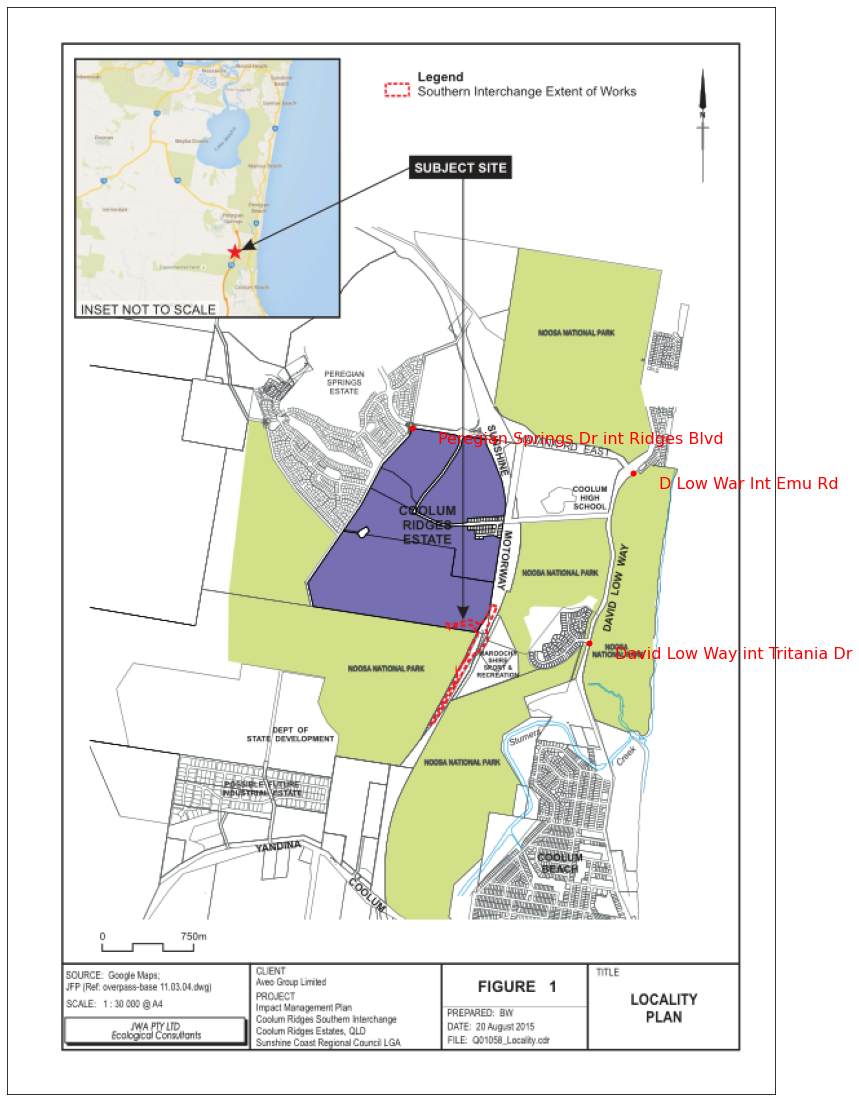

In [48]:
def evaluate_paraboloid(x,y,A,coeff):
    c = copy.deepcopy(coeff)
    x = np.array(x)
    y = np.array(y)
    for i in range(len(x.shape)):
        c = np.expand_dims(c, axis=1)
    return (c*A(x,y)).sum(axis=0)


root = tk.Tk()
root.attributes('-zoomed', True)
app = gui.Choose_Map_Template(
    root, map_templates, page_num, base_dir + sub_dir + '/pages/',
    title = 'Choose a map template'
)
root.mainloop()

if app.v.get() >= 0:
    t_page_num = map_templates[app.v.get()]

    if len(np.array(coord_dict[str(t_page_num)][0])) <= 7:
        c_lon = np.array(coord_dict[str(t_page_num)][0])
        c_lat = np.array(coord_dict[str(t_page_num)][1])
        
        if len(c_lon) == 3:
            A = lambda x,y: np.array([x*0+1, x, y])
        elif len(c_lon) == 6:
            A = lambda x,y: np.array([x*0+1, x, y, x**2, x*y, y**2])
        else: 
            A = None
        
        x = np.arange(im1.shape[1])/im1.shape[1]
        y = np.arange(im1.shape[0])/im1.shape[0]
        XX, YY = np.meshgrid(x, y)

        LON = np.round(evaluate_paraboloid(XX, YY, c_lon), 6)
        LAT = np.round(evaluate_paraboloid(XX, YY, c_lat), 6)
    else:
        LON = np.array(coord_dict[str(t_page_num)][0])
        LAT = np.array(coord_dict[str(t_page_num)][1])
        
elif app.v.get() == -1:
    json_files = glob.glob(base_dir + sub_dir + '/JSON/edited/*.json')
    json_names = [j.split('/')[-1].split('.')[0] for j in json_files]

    path = base_dir + sub_dir + '/pages/' + file_name

    root = tk.Tk()
    root.attributes('-zoomed', True)
    app = gui.Choose_Points(root, im1, text_list = json_names)
    root.mainloop()

    points = app.points
    names = app.names

    fig, ax = plt.subplots(1, figsize=(20,20))
    ax.imshow(im1)
    for i in range(len(points)):
        ax.plot(points[i][0], points[i][1], '.r', markersize=10)
        ax.text(
            points[i][0]+20, points[i][1]+12, names[i], color='r', 
            fontsize=16
        )
        plt.tick_params(        
            which='both',     
            bottom=False,     
            top=False,
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False
        )
    fig.savefig(base_dir + sub_dir + '/' +str(page_num) + '/reference.png')
    plt.show(block=False)

    if np.any([n not in json_names for n in names]):
        approx_lon = input(
            'Enter approx. lon. of top left map corner in dec. degrees '
            + '(e.g. 150.12345678): '
        )
        approx_lon = float(approx_lon)
        approx_lat = input(
            'Enter approx. lat. of top left map corner in signed dec. degrees '
            + '(e.g. -25.12345678): '
        )
        approx_lat = float(approx_lat)
        approx_spread = input(
            'Enter approx. width of map in dec. degrees (e.g. 0.05): '
        )
        approx_spread = float(approx_spread)

        scaled_points = [
            (
                approx_spread*x[0]/im1.shape[0] + approx_lon,
                -approx_spread*x[1]/im1.shape[1] + approx_lat
            ) for x in points
        ]

    subprocess.run('rm -r ' + base_dir + sub_dir + '/JSON/raw', shell=True)
    subprocess.run('mkdir -p ' + base_dir + sub_dir + '/JSON/raw', shell=True)
    subprocess.run('mkdir -p ' + base_dir + sub_dir + '/JSON/edited', shell=True)

    if np.any([n not in json_names for n in names]) or not json_names:
        json_features = []
        for i in range(len(scaled_points)):
            json_feature = geojson.Feature(
                geometry=geojson.Point(
                    scaled_points[i], precision=8, properties={'Name': names[i]}
                )
            )
            json_features.append(json_feature)

        for i in range(len(json_features)):
            if names[i] not in json_names:
                f = open(
                    base_dir + sub_dir + '/JSON/raw/' + names[i] + '.json', 
                    'w'
                )
                f.write(
                    geojson.dumps(
                        json_features[i], sort_keys=True, indent=4
                    )
                )
                f.close()

        subprocess.run(
            'cp ' + base_dir + '/reference.qgs ' + base_dir 
            + sub_dir + '/reference.qgs', shell=True
        )

        cmd=(
            'qgis --project ' + base_dir + sub_dir + '/reference.qgs ' 
            + base_dir + sub_dir + '/JSON/raw/*.json --extent {},{},{},{}'
        ).format(
            approx_lon, 
            approx_lat+np.sign(approx_lat)*approx_spread,
            approx_lon+approx_spread, 
            approx_lat-np.sign(approx_lat)*approx_spread,
        )
        subprocess.run(cmd, shell=True)

        subprocess.run(
            'mv ' + base_dir + sub_dir + '/JSON/raw/*json '
            + base_dir + sub_dir + '/JSON/edited/', shell=True
        )

    coords = []
    for i in range(len(points)):
        f = open(base_dir + sub_dir + '/JSON/edited/' + names[i] + '.json', 'r')
        coords.append(geojson.loads(f.read()))
        f.close()

    rows = np.array([point[1] for point in points])
    cols = np.array([point[0] for point in points])
    lons = np.array(
        [coord['geometry']['coordinates'][0] for coord in coords]
    )
    lats = np.array(
        [coord['geometry']['coordinates'][1] for coord in coords]
    )

    X = cols/im1.shape[1]
    Y = rows/im1.shape[0]

    if len(rows) < 3:
        A = None
    elif len(rows) < 7:
        A = lambda x,y: np.array([x*0+1, x, y])
    else:
        A = lambda x,y: np.array([x*0+1, x, y, x**2, x*y, y**2])

    c_lon, residuals, rank, s = np.linalg.lstsq(A(X,Y).T, lons, rcond=1e-8)
    c_lat, residuals, rank, s = np.linalg.lstsq(A(X,Y).T, lats, rcond=1e-8)

    def evaluate_paraboloid(x,y,coeff):
        c = copy.deepcopy(coeff)
        x = np.array(x)
        y = np.array(y)
        for i in range(len(x.shape)):
            c = np.expand_dims(c, axis=1)
        return (c*A(x,y)).sum(axis=0)

    x = np.arange(im1.shape[1])/im1.shape[1]
    y = np.arange(im1.shape[0])/im1.shape[0]
    XX, YY = np.meshgrid(x, y)

    LON = np.round(evaluate_paraboloid(XX, YY, c_lon), 6)
    LAT = np.round(evaluate_paraboloid(XX, YY, c_lat), 6)
    
    coord_dict[str(page_num)] = [c_lon.tolist(), c_lat.tolist()]
    with open(base_dir + sub_dir + '/coord_dict.json', 'w') as f:
        json.dump(coord_dict, f, indent=4)

In [47]:
c_lat

array([-2.64650150e+01,  7.18727718e-05, -7.88655815e-02])

In [35]:
def hex_to_kml_hex(hex_col, with_hash=True, alpha='ff'):
    if with_hash:
        kml_hex = hex_col[1:]
    kml_hex = alpha + kml_hex[6:] + kml_hex[4:6] + kml_hex[2:4] + kml_hex[0:2]
    return kml_hex

poly_line=[]
poly_fill=[]
for i in range(len(svg_fill)):
    if svg_stroke[i] == 'none' and svg_fill[i] != 'none':
        poly_line.append(hex_to_kml_hex(svg_fill[i], alpha='ff'))
        poly_fill.append(hex_to_kml_hex(svg_fill[i], alpha='80'))

    elif svg_fill[i] == 'none' and svg_stroke[i] != 'none':
        poly_fill.append(hex_to_kml_hex(svg_stroke[i], alpha='80'))
        poly_line.append(hex_to_kml_hex(svg_stroke[i], alpha='ff'))
    else:
        poly_fill.append('80ff0000')
        poly_fill.append('ffff0000')    

subprocess.run(
    'mkdir ' + base_dir + sub_dir + '/' + str(page_num), 
    shell=True
)

subprocess.run(
    'rm ' + base_dir + sub_dir + '/' + str(page_num) 
    + '/svg.kml', shell=True
)

def gen_poly_coords(coords, LON, LAT):
    poly_coords = [
        [
            (
                LON[
                    coords[i][j][0][1],
                    coords[i][j][0][0]
                ],
                LAT[
                    coords[i][j][0][1],
                    coords[i][j][0][0]
                ],
                1.0
            )
            for j in range(len(coords[i]))
        ]
        for i in range(len(coords))
    ]
    return poly_coords

kml = simplekml.Kml()
kml.document.name = str(page_num) + '_svg'

styles = []
for i in range(len(svg_coords)):
    sty = simplekml.Style()
    sty.linestyle.width = 2
    sty.linestyle.color = poly_line[i]
    sty.polystyle.color = poly_fill[i]
    styles.append(sty)
            
poly_coords = gen_poly_coords(svg_coords, LON, LAT)

for name in set(poly_names):
    fol = kml.newfolder(name=name)
    poly_inds = np.where(np.array(poly_names)==name)[0].tolist()
    for j in range(len(poly_inds)):
        if poly_coords[poly_inds[j]][0] == poly_coords[poly_inds[j]][-1]:
            poly = fol.newpolygon(
                name = name + ' ' + str(j+1),
                outerboundaryis = poly_coords[poly_inds[j]],
                altitudemode='relativetoground',                
            )
        else:
            poly = fol.newlinestring(
                name = name + ' ' + str(j+1),
                coords = poly_coords[poly_inds[j]],
                altitudemode='relativetoground',              
            )
        poly.style = styles[poly_inds[j]]

if cp_coords:
    unique_cp_names = list(set(cp_names))
    num_colours = len(unique_cp_names)
    alpha=0.75
    cm = pylab.get_cmap('Set1')
    poly_colours = []
    line_colours = []

    for i in range(num_colours):
        cp = list(cm(1.*i/num_colours))
        cline = copy.deepcopy(cp)
        cp[3] = alpha
        cp = to_hex(cp, keep_alpha=True)[1:]
        cp = cp[6:]+cp[4:6]+cp[2:4]+cp[0:2]
        poly_colours.append(cp)
        cline = (np.array(cline)*0.8).tolist()
        cline[3] = alpha

        cline = to_hex(cline, keep_alpha=True)[1:]
        cline = cline[6:]+cline[4:6]+cline[2:4]+cline[0:2]
        line_colours.append(cline)

    styles = {}
    for i in range(len(unique_cp_names)):
        sty = simplekml.Style()
        sty.linestyle.width = 2
        sty.linestyle.color = poly_colours[i]
        sty.polystyle.color = line_colours[i]
        styles[unique_cp_names[i]]= sty

    poly_coords = gen_poly_coords(cp_coords, LON, LAT)

    for name in unique_cp_names:
        fol = kml.newfolder(name=name)
        poly_inds = np.where(np.array(cp_names)==name)[0].tolist()
        for j in range(len(poly_inds)):
            if poly_coords[poly_inds[j]][0] == poly_coords[poly_inds[j]][-1]:
                poly = fol.newpolygon(
                    name = name + ' ' + str(j+1),
                    outerboundaryis = poly_coords[poly_inds[j]],
                    altitudemode='relativetoground',                
                )
            else:
                poly = fol.newlinestring(
                    name = name + ' ' + str(j+1),
                    coords = poly_coords[poly_inds[j]],
                    altitudemode='relativetoground',              
                )
            poly.style = styles[name]
kml.save(
    base_dir + sub_dir + '/' 
    + str(page_num) + '/svg.kml'
)

subprocess.run(
    'cp ' + base_dir + '/reference.qgs ' + base_dir 
    + sub_dir + '/reference.qgs', shell=True
)

cmd=(
    'qgis --project ' + base_dir + sub_dir + '/reference.qgs ' 
    + base_dir + sub_dir + '/' + str(page_num) 
    + '/svg.kml --extent {},{},{},{}'
).format(np.min(LON), np.min(LAT), np.max(LON), np.max(LAT))

if (svg_coords+cp_coords):
    subprocess.run(cmd, shell=True)

## Extract from image

In [102]:
small_soup = BeautifulSoup(svg)

f = open(
    base_dir + sub_dir + '/' + str(page_num) + '/full_image.svg', 'w')
f.write(soup_tap.svg.prettify())
f.close()

[s.decompose() for s in small_soup('path')]
[s.decompose() for s in small_soup('text')]

for s in small_soup('image'):
    transform = convert_transform(s.parent.parent['transform'])
    img_width = abs(float(s['width'])*transform[0,0])
    img_height = abs(float(s['height'])*transform[1,1])
    if img_width > 0.6*p_width:
        continue
    elif img_height > 0.6*p_height:
        continue
    s.decompose()
    
fname = base_dir + sub_dir + '/' + str(page_num) + '/no_overlays.svg'
f = open(fname, 'w')
f.write(small_soup.svg.prettify())
f.close()

cmd = (
    'inkscape {} --export-filename={} '
    + '--export-background=FFFFFFFF --export-area=0:0:{}:{}'
).format(
    fname, base_dir + sub_dir + '/' + str(page_num) + '/no_overlays.png',
    np.ceil(p_width).astype(int), np.ceil(p_height).astype(int)
)
subprocess.run(cmd, shell=True)

im1 = imread(base_dir + sub_dir + '/' + str(page_num) + '/no_overlays.png')

try:
    print(cp_names)
except:
    cp_names = []

[]


In [104]:
root = tk.Tk()
# root.attributes('-zoomed', True)
root.geometry(
    str(round(1.1*im1.shape[1])) + 'x' + str(round(1.1*im1.shape[0]))
)
app = gui.Define_Training_Regions(
    root, im1, sorted(list(set(leg_text_all_corrected + cp_names))), 
    legend=leg_im
)
root.mainloop()

CompletedProcess(args='qgis --project /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/map_data/20157598_12042016/reference.qgs /home/student.unimelb.edu.au/shorte1/Documents/ACF_consulting/map_data/20157598_12042016/128/image.kml --extent 153.02848,-26.543443,153.138967,-26.473899', returncode=0)

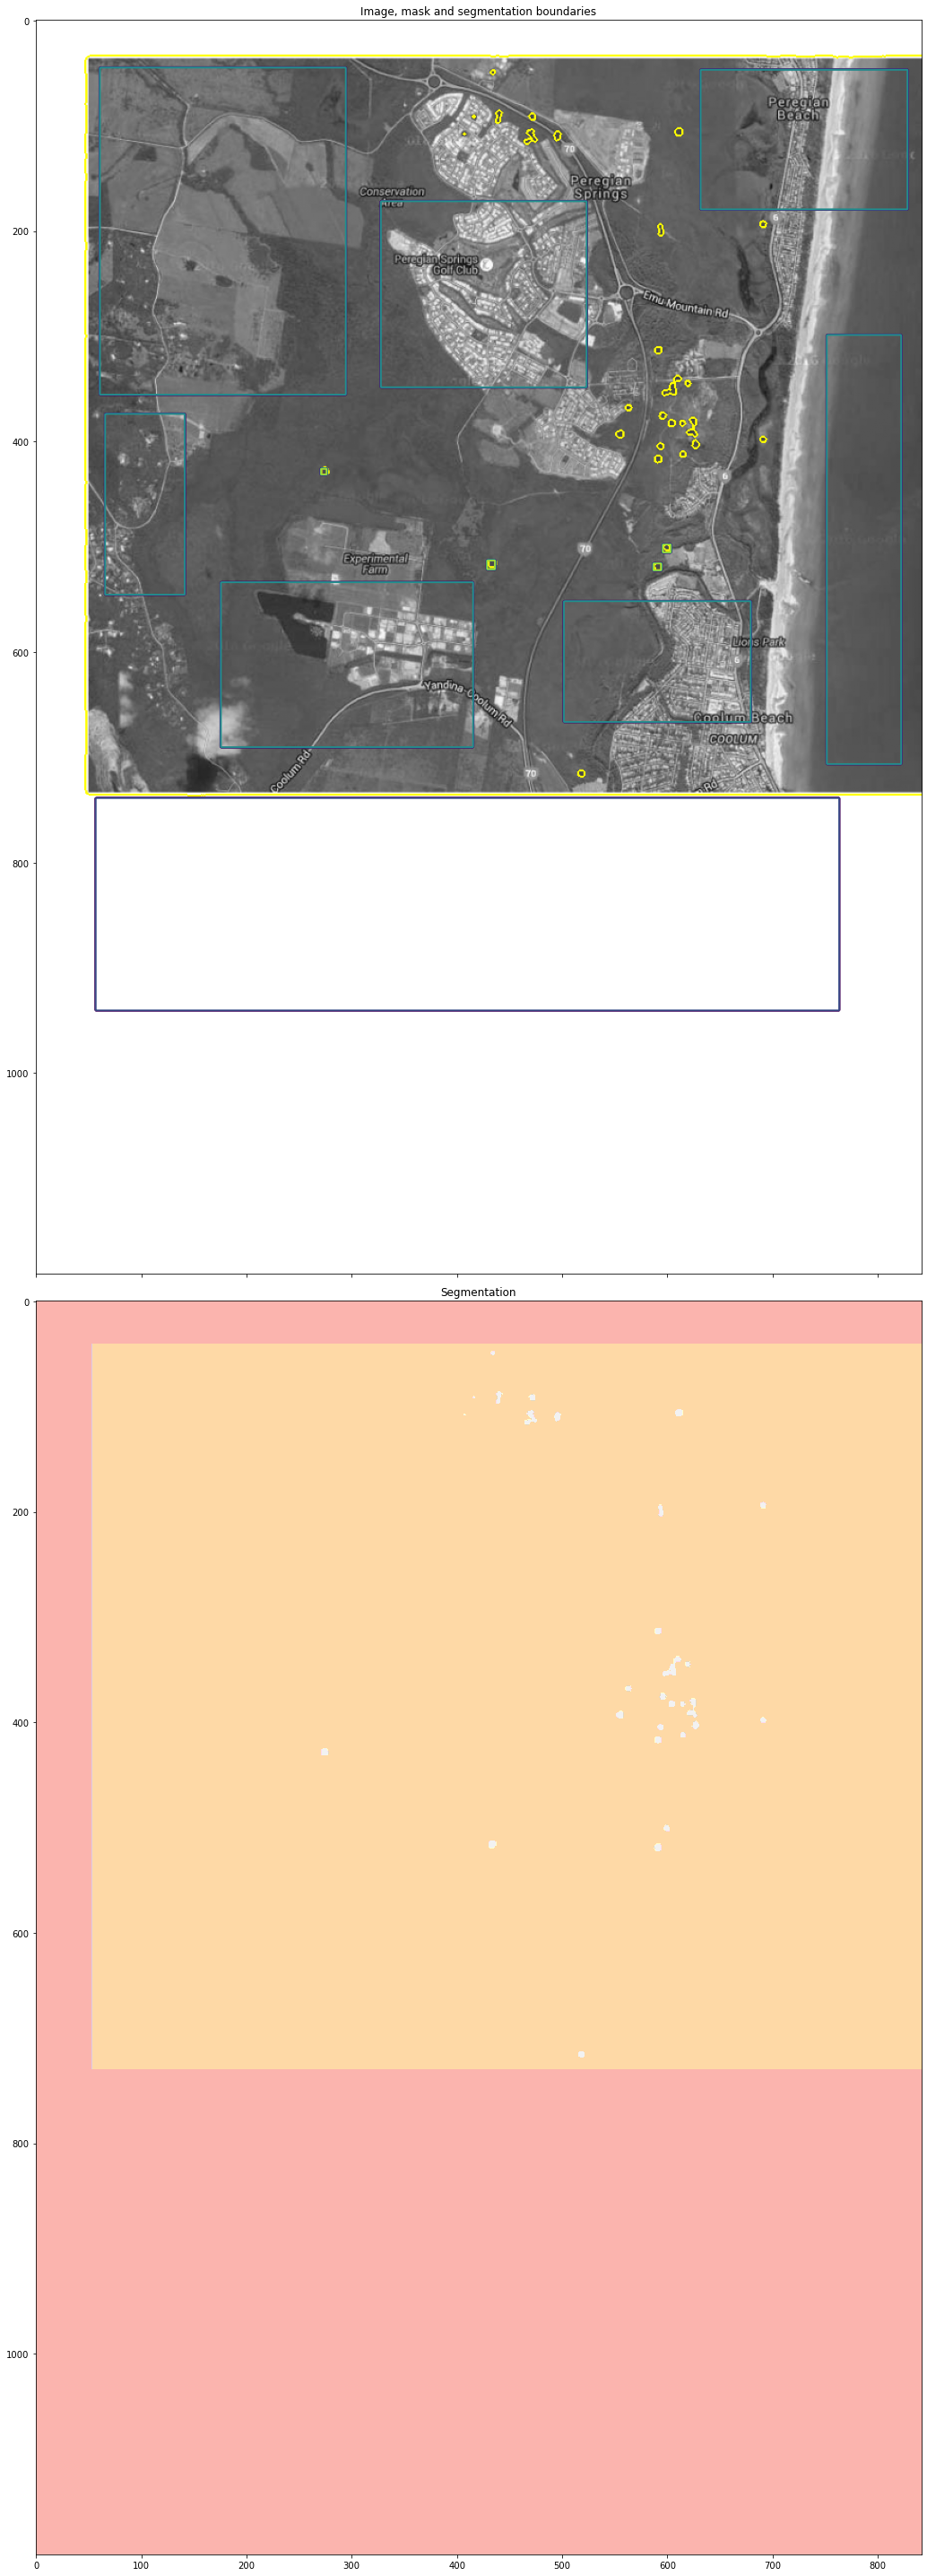

In [105]:
training_labels = np.zeros(im1.shape[:2])
for i in range(len(app.boxes)):
    for box in app.boxes[i]:
        training_labels[box[1]:box[3], box[0]:box[2]] = i+1

sigma_min = 1
sigma_max = 2
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=True,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)
features = features_func(im1)
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1,
                             max_depth=10, max_samples=0.05)
clf = future.fit_segmenter(training_labels, features, clf)
result = future.predict_segmenter(features, clf)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20, 40))
gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
ax[0].imshow(segmentation.mark_boundaries(gray, result, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Image, mask and segmentation boundaries')

poly_box = np.zeros(im1.shape[:2])
poly_box[pb_tl[1]:pb_br[1], pb_tl[0]:pb_br[0]]=1
poly_box = poly_box.astype(bool)
poly_box = np.logical_not(poly_box)
result[poly_box] = 1

ax[1].imshow(result, cmap='Pastel1')
ax[1].set_title('Segmentation')
fig.tight_layout()

root = tk.Tk()
app_choose = gui.Choose_Kept_Categories(
    root, app.names
)
root.mainloop()

result = median(result, selem=np.ones([2,2]))

inds = (np.where([v.get() for v in app_choose.v])[0]+1).tolist()

poly_colours = []
line_colours = []
alpha='80'
for i in inds:
    try:
        cp = im1[result==i].mean(axis=0)/255
        cp = to_hex(cp, keep_alpha=True)[1:]
        cp = cp[6:]+cp[4:6]+cp[2:4]+cp[0:2]
        line_colours.append(cp)
        cp_fill = copy.deepcopy(cp)
        cp_fill = alpha + cp_fill[2:]
        poly_colours.append(cp_fill)
    except:
        line_colours.append('ff000000')
        poly_colours.append('80000000')
        
kml = simplekml.Kml()
kml.document.name = str(page_num) + '_image'

styles = []
for i in range(len(inds)):
    sty = simplekml.Style()
    sty.linestyle.width = 2
    sty.linestyle.color = line_colours[i]
    sty.polystyle.color = poly_colours[i]
    styles.append(sty)
    
for i in range(len(inds)):
#     filled = ndi.binary_fill_holes(result==inds[i])
    filled = (result==inds[i])
    obj_size_ratio = 5e-10
    min_size = int(obj_size_ratio*im1.shape[0]*im1.shape[1])
    filled = remove_small_objects(filled, min_size = min_size)
#     filled = ndi.binary_fill_holes(filled)
    
    label_objects, nb_labels = ndi.label(filled)
    label_objects = label_objects.astype(np.uint8)
    
    obj_contours, hierarchy = cv.findContours(
        label_objects, cv.RETR_CCOMP, cv.CHAIN_APPROX_TC89_L1
    )
    
    smooth_obj_contours = []
    for cnt in obj_contours:
        epsilon = 0.0001*cv.arcLength(cnt,True)
        smooth_obj_contours.append(
            cv.approxPolyDP(cnt,epsilon,True)
        )
            
    poly_coords = gen_poly_coords(smooth_obj_contours, LON, LAT)
        
    if poly_coords:
        fol = kml.newfolder(name=app.names[inds[i]-1])
        parents = np.argwhere(hierarchy[0][:,3]==-1).flatten()
        for j in range(len(parents)):
            poly = fol.newpolygon(
                name = app.names[inds[i]-1] + ' ' + str(j+1),
                outerboundaryis = (
                    poly_coords[parents[j]] 
                    + [poly_coords[parents[j]][0]]
                ),
                altitudemode='relativetoground',                
            )
            children = np.argwhere(
                hierarchy[0][:,3]==parents[j]
            ).flatten()
            if len(children) > 0:
                inner_boundaries = []
                for k in range(len(children)):
                    if len(poly_coords[children[k]]) > 3:
                        inner_boundaries.append(
                            poly_coords[children[k]]
                            + [poly_coords[children[k]][0]]
                        )
                poly.innerboundaryis = inner_boundaries
            poly.style = styles[i]
kml.save(base_dir + sub_dir + '/' + str(page_num) + '/image.kml')

subprocess.run(
    'cp ' + base_dir + '/reference.qgs ' + base_dir 
    + sub_dir + '/reference.qgs', shell=True
)

cmd=(
    'qgis --project ' + base_dir + sub_dir + '/reference.qgs ' 
    + base_dir + sub_dir + '/' + str(page_num) 
    + '/image.kml --extent {},{},{},{}'
).format(np.min(LON), np.min(LAT), np.max(LON), np.max(LAT))

subprocess.run(cmd, shell=True)

In [46]:
remaining_pages.remove(page_num)
np.savetxt(base_dir + sub_dir + "/remaining_pages.csv", remaining_pages, delimiter=",")